In [10]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [11]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [12]:
from pandas import read_csv

table = read_csv('Quadranti.csv')

Moggio = table.loc[:, ["Date", "PM10", "Ammonia",
                       "Wind_speed", "Quadrante", "Temperature", "Rainfall"]]
Moggio = table.dropna(how="any")
Moggio = Moggio.reset_index()

values = Moggio.iloc[:,3:].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_features = 7 # number of variables, including the one to be predicted
n_train_days = 1667-365 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

(1302, 35) 1302 (1302,)


In [13]:
reframed

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var1(t-4),var2(t-4),var3(t-4),...,var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
5,0.0,0.066667,0.088608,0.163005,0.286365,0.000000,0.333333,0.0,0.066667,0.063291,...,0.161552,0.333333,0.0,0.033333,0.101266,0.246694,0.358295,0.112816,0.333333,0.0
6,0.0,0.066667,0.063291,0.130139,0.282413,0.035199,0.333333,0.0,0.122222,0.050633,...,0.112816,0.333333,0.0,0.022222,0.025316,0.075776,0.406390,0.000000,0.000000,0.0
7,0.0,0.122222,0.050633,0.074531,0.353183,0.000000,0.333333,0.0,0.066667,0.088608,...,0.000000,0.000000,0.0,0.077778,0.088608,0.034263,0.397825,0.000000,0.000000,0.0
8,0.0,0.066667,0.088608,0.381024,0.350999,0.161552,0.333333,0.0,0.033333,0.101266,...,0.000000,0.000000,0.0,0.044444,0.050633,0.201140,0.408315,0.000000,0.333333,0.0
9,0.0,0.033333,0.101266,0.246694,0.358295,0.112816,0.333333,0.0,0.022222,0.025316,...,0.000000,0.333333,0.0,0.044444,0.088608,0.063516,0.392536,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027,0.0,0.022222,0.012658,0.036869,0.451474,0.000903,0.000000,0.0,0.033333,0.025316,...,0.000000,1.000000,0.0,0.022222,0.000000,0.085947,0.273317,0.000000,0.000000,0.0
2028,0.0,0.033333,0.025316,0.180093,0.432863,0.000000,0.000000,0.0,0.011111,0.037975,...,0.000000,0.000000,0.0,0.044444,0.063291,0.114757,0.198201,0.000000,0.000000,0.0
2029,0.0,0.011111,0.037975,0.168651,0.437366,0.000000,0.000000,0.0,0.022222,0.037975,...,0.000000,0.000000,0.0,0.022222,0.063291,0.126405,0.216521,0.124549,0.333333,0.0
2030,0.0,0.022222,0.037975,0.353177,0.341878,0.000000,1.000000,0.0,0.022222,0.000000,...,0.124549,0.333333,0.0,0.022222,0.000000,0.383468,0.293780,0.009928,0.333333,0.0


In [14]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
       # hp_units = hp.Int('units', min_value=10, max_value=60, step=10)
        hp_units = 50
        model = Sequential()
        model.add(LSTM(units = hp_units,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(LSTM(units = hp_units, return_sequences=True))
        model.add(LSTM(units = hp_units, return_sequences=False))
        model.add(Dense(1))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128]),
            **kwargs,
        )


In [15]:
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=10,
    executions_per_trial =5,
    overwrite=True,
    directory = 'dir',
    project_name = 'tune_hypermodel')
tuner.search_space_summary()

Search space summary
Default search space size: 1
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [16]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
tuner.search(train_X, train_y, epochs=100, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])

Trial 9 Complete [00h 01m 14s]
val_loss: 0.13599877655506135

Best val_loss So Far: 0.07203124314546586
Total elapsed time: 00h 17m 16s
INFO:tensorflow:Oracle triggered exit


In [17]:
tuner.results_summary()

Results summary
Results in dir/tune_hypermodel
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 64
Score: 0.07203124314546586
Trial summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 32
Score: 0.0744924247264862
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 64
Score: 0.07589457035064698
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 16
Score: 0.11018052101135253
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 128
Score: 0.12724721133708955
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 64
Score: 0.13599877655506135
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 128
Score: 0.13886790871620178
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 16
Score: 0.14104715287685393
Trial summary
Hyperparameters:
learning_rate: 0.01
batch_size: 16
Score: 0.14753933846950532


In [18]:
model = tuner.get_best_models()[0]
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             11600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 52,051
Trainable params: 52,051
Non-trainable params: 0
_________________________________________________________________


In [19]:
# make a prediction using 2020 (not used for training or validation, and has different dynamics due to covid)
# adding back the data from 2020
Moggio = table.dropna(how="any")
Moggio = Moggio.reset_index()
#scaling and creating the new testing data
values = Moggio.iloc[:,3:].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)
# split into train and test sets
values = reframed.values
n_features = 7 # number of variables, including the one to be predicted
n_train_days = 365 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(365, 35) 365 (365,)


2022-02-22 21:54:57.477872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 21:54:57.529461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 21:54:57.646275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 21:54:57.756889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Test RMSE: 1.923


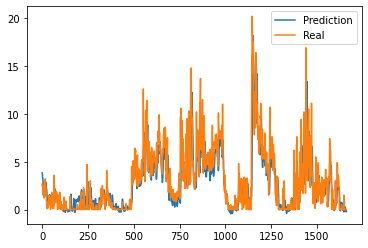

In [21]:
pyplot.plot(inv_yhat, label = 'Prediction')
pyplot.plot(inv_y, label = 'Real')
pyplot.legend()
pyplot.show()